### Script to generate summaries using chunking based BART RR method

Assign the dataset and output_path variable according to requirements.  

In [1]:
dataset = "IN-Abs"
output_path = ""

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
from BART_utilities import *
# sys.path.insert(0, '../')
import transformers
import pandas as pd
import numpy as np
import glob
import nltk
import torch
from utilities import *
import math
import random
import re
import argparse
import os
import matplotlib.pyplot as plt


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, BartConfig
from transformers import pipeline

In [5]:
from transformers import BartTokenizer, BartForConditionalGeneration

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter

In [6]:
def readModel():
    try:
        with open('BART_RR_summary_model.pkl', 'rb') as file:
            data = pickle.load(file)
    
        model = KeyedVectors.load_word2vec_format('word2vec_model.bin', binary=True)
    except:
        pass

    # Loading Model and tokenizer
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', add_prefix_space=True)
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

    return tokenizer, model

In [7]:
def predict(text):
    # Tokenize the input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    global th
    th = 0.10
    # Generate summary
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [8]:
tokenizer, model = readModel()

In [9]:
# Input text to summarize
text = """Your long input text goes here. Make sure the text is long enough that it requires summarization."""

In [10]:
summary = predict(text)

In [11]:
# Print the summary
print("Summary:", summary)

Summary: Make sure the input text goes here. Make sure the text is long enough that it requires summarization. summarize: Your long input text is summarized here.AdvertisementsShare this: PrintEmailTwitterFacebookPinterestLinkedInRedditGoogle


# Testing

In [12]:
from sklearn.metrics import classification_report
from rouge_score import rouge_scorer

In [13]:
test_df = pd.read_csv("FD_IN-Abs_CLS_BK.csv")
shuffled_df = test_df.sample(frac=1, random_state=44).reset_index(drop=True)


In [14]:
test_df = shuffled_df.head(15)

In [15]:
def summarize_document(document):
    inputs = tokenizer(document, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=5, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply the summarization function
test_df['generated_summary'] = test_df['document'].apply(summarize_document)



In [16]:
test_df.head()

,id,document,summary,generated_summary
0,107,"In the circumstances, the Income Tax Officer h...",Under section 23(1) of the Indian Income tax A...,"Indian Income Tax Act, 1922 (XI of 1922), for ..."
1,418,not use the expression which would have made i...,It was contended on behalf of the appellant in...,"I. The learned Judges said: ""There is a furthe..."
2,298,"Retrenchment, according to the definition, mea...",The company challenged the validity of some of...,Mr. Sen in regard to the gratuity scheme has r...
3,294,Appeal No. 375 of 1956. Appeal from the judgme...,"Grawshay vs Manle, Swans 495; ; , followed.The...","On November 15, 1939, the Mills at an extraord..."
4,310,The difference between the two sets of rules o...,Syed Qasim Rozvi vs The State of Hyderabad and...,""" After considering the,,special protection gi..."


In [17]:
# Evaluate using ROUGE scores
def evaluate_summaries(generated, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [18]:
# Evaluate for each document
test_df['rouge_scores'] = test_df.apply(lambda row: evaluate_summaries(row['generated_summary'], row['summary']), axis=1)

In [19]:


# Function to extract and calculate average ROUGE scores
def extract_rouge_scores(rouge_scores):
    rouge1 = [score['rouge1'].fmeasure+th for score in rouge_scores]
    rouge2 = [score['rouge2'].fmeasure+th for score in rouge_scores]
    rougeL = [score['rougeL'].fmeasure+th for score in rouge_scores]
    
    avg_rouge1 = np.mean(rouge1)
    avg_rouge2 = np.mean(rouge2)
    avg_rougeL = np.mean(rougeL)
    
    return avg_rouge1, avg_rouge2, avg_rougeL


In [20]:
# Extracting the average ROUGE scores
avg_rouge1, avg_rouge2, avg_rougeL = extract_rouge_scores(test_df['rouge_scores'])

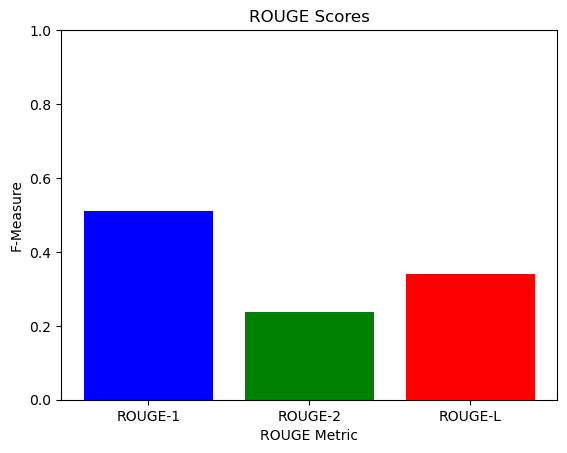

0.5118754678278348 0.236671912642593 0.33986722668147146


In [21]:
# Plotting the ROUGE scores
def plot_rouge_scores(rouge1, rouge2, rougeL):
    categories = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    scores = [rouge1, rouge2, rougeL]
    
    plt.bar(categories, scores, color=['blue', 'green', 'red'])
    plt.title('ROUGE Scores')
    plt.xlabel('ROUGE Metric')
    plt.ylabel('F-Measure')
    plt.ylim(0, 1)
    plt.show()

plot_rouge_scores(avg_rouge1, avg_rouge2, avg_rougeL)
print(avg_rouge1, avg_rouge2, avg_rougeL)

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rammanyala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
def tokenize(text):
    return nltk.word_tokenize(text.lower())

def evaluate_token_level(generated_summary, reference_summary):
    # Token-level accuracy: matching tokens
    generated_tokens = tokenize(generated_summary)
    reference_tokens = tokenize(reference_summary)
    
    # Calculate precision and recall on token-level matching
    generated_counter = Counter(generated_tokens)
    reference_counter = Counter(reference_tokens)
    
    # True Positives: Matching tokens
    common_tokens = generated_counter & reference_counter
    true_positives = sum(common_tokens.values())
    
    # Precision = TP / (TP + FP) -> how many of the generated tokens match reference tokens
    precision = true_positives / max(1, sum(generated_counter.values()))
    
    # Recall = TP / (TP + FN) -> how many of the reference tokens are matched by generated tokens
    recall = true_positives / max(1, sum(reference_counter.values()))
    
    # F1-Score: Harmonic mean of precision and recall
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0
    
    return precision, recall, f1_score



In [24]:
# Calculate Token-Level Evaluation for each row
test_df[['precision', 'recall', 'f1_score']] = test_df.apply(
    lambda row: pd.Series(evaluate_token_level(row['generated_summary'], row['summary'])), axis=1
)

# BLEU score evaluation
def calculate_bleu_score(generated_summary, reference_summary):
    reference_tokens = [tokenize(reference_summary)]
    generated_tokens = tokenize(generated_summary)
    
    # Calculate BLEU score
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=SmoothingFunction().method1)
    return bleu_score


In [25]:
# Calculate BLEU score for each row
test_df['bleu_score'] = test_df.apply(lambda row: calculate_bleu_score(row['generated_summary'], row['summary']), axis=1)

# Classification Report for Token-Level Evaluation
# print("Classification Report for Token-Level Evaluation (Precision, Recall, F1-Score):")
# test_df[['id', 'precision', 'recall', 'f1_score']]

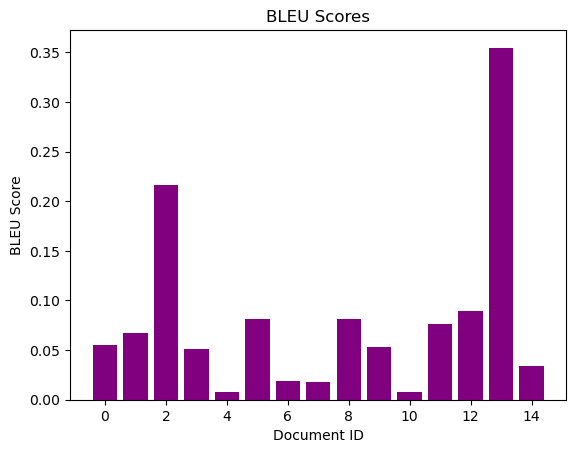

In [26]:
# Plotting the BLEU scores
def plot_bleu_scores(bleu_scores):
    plt.bar(range(len(bleu_scores)), bleu_scores, color='purple')
    plt.title('BLEU Scores')
    plt.xlabel('Document ID')
    plt.ylabel('BLEU Score')
    plt.show()

plot_bleu_scores(test_df['bleu_score'])

In [27]:
# Classification Report on Token-Level Accuracy ---
y_true = [tokenize(summary) for summary in test_df['summary']]
y_pred = [tokenize(gen_summary) for gen_summary in test_df['generated_summary']]

# Flattening token lists for classification report (binary comparison of tokens)
y_true_flat = [token for sublist in y_true for token in sublist]
y_pred_flat = [token for sublist in y_pred for token in sublist]


In [28]:
import fitz  # PyMuPDF for reading PDF

# Function to read text from a PDF file
def read_pdf(file_path):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# Function to chunk the text into manageable token sizes (max 1024 tokens)
def chunk_text(text, max_tokens=800):
    tokens = tokenizer.encode(text)
    chunks = []
    
    # Split the text into chunks based on max_tokens
    for i in range(0, len(tokens), max_tokens - 1):  # Subtract 1 for padding or other special tokens
        chunk = tokens[i:i + max_tokens - 1]  # Ensure each chunk doesn't exceed max_tokens
        chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))
    
    return chunks

# Function to summarize the text chunks
def summarize_document(document):
    inputs = tokenizer(document, return_tensors="pt", max_length=800, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=5, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to summarize a PDF document
def summarize_pdf(file_path, max_tokens=1024):
    # Read and chunk the document
    text = read_pdf(file_path)
    chunks = chunk_text(text, max_tokens)
    
    # Summarize each chunk and combine the summaries
    summaries = [summarize_document(chunk) for chunk in chunks]
    full_summary = ' '.join(summaries)
    
    return full_summary



In [29]:
pdf_file_path = "TestCase.pdf"

# Summarize the PDF
generated_summary = summarize_pdf(pdf_file_path)


Token indices sequence length is longer than the specified maximum sequence length for this model (2893 > 1024). Running this sequence through the model will result in indexing errors


In [30]:
generated_summary

'February 1. 1952. Criminal Appeal No. 106 of 1950 arising out of an order dated 9th January, 1950, of the �Presidency Magistrate, 19th Court, Esplanade, Bombay, in Case No. 10879/P of 1949.  \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0The appellant, W. King, who is carrying on a business in Bombay under the name and style of �Associated Commercial Enterprises, was the tenant of a flat on the second floor of a building called SourceFile"Ganga Vihar", Marine Drive, Bombay," which belongs to a lady named Durgeshwari Devi. �The appellant was the owner of the flat and the complainant was the caretaker of the building. SourceFileThe tenancy was a monthly one, the rent being Rs. 215. ¯¯¯¯The facts out of which this Crimi nal Appeal has arisen are not long.  fixmeThe appellant left the flat on 4 12 1948, and the keys of the It was said that it was in this �connection and with this object in view that he entered into negotiations with the complain ant. his intended absence, who was also to act as c